# Discover Symmetry of Kepler in 2D (Training)

## Import packages

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from glob import glob
from netCDF4 import Dataset

from scipy.integrate import odeint
# from functools import partial
# import multiprocessing

In [2]:
torch.manual_seed(8407)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Play with Data

* Data: $(x,y,v_x,v_y)$


* Hamiltonian:
    $$H = \frac{p^2}{2m} - \frac{GMm}{r}$$
    

* Hamilton's Equation of motion (assume $m=1$):

    \begin{align}
    \dot{x} &= \partial_{p_x}H = p_x = v_x \\
    \dot{v_x} &= -\partial_x H = -\frac{GM}{r^3}x \\
    \dot{y} &= \partial_{p_y}H = p_y = v_y \\
    \dot{v_y} &= -\partial_y H = -\frac{GM}{r^3}y
    \end{align}

In [4]:
G = 1
M = 1

In [5]:
def eom(z, t):
    x, y, vx, vy = z
    dxdt = vx
    dydt = vy
    dvxdt = - G * M / (x**2 + y**2)**(3/2) * x
    dvydt = - G * M / (x**2 + y**2)**(3/2) * y
    return [dxdt, dydt, dvxdt, dvydt]

In [6]:
z0 = [1, 1, -0.3, 0.3]
print(z0)
t = torch.linspace(0, 5, 1000)

[1, 1, -0.3, 0.3]


In [7]:
z = odeint(eom, z0, t)

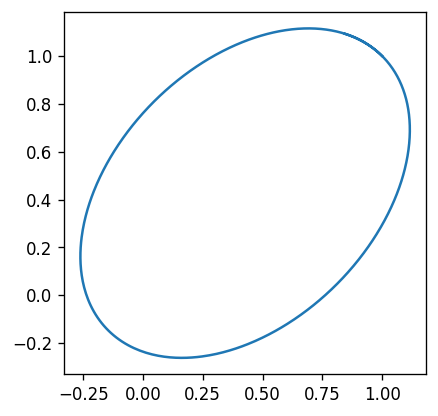

In [8]:
plt.figure(dpi=120)
plt.plot(z[:,0], z[:,1])
ax = plt.gca()
ax.set_aspect("equal")

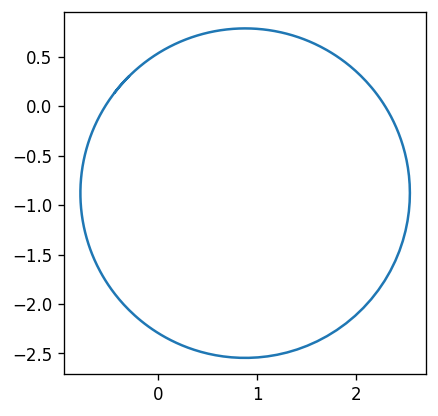

In [9]:
plt.figure(dpi=120)
plt.plot(z[:,2], z[:,3])
ax = plt.gca()
ax.set_aspect("equal")

In [10]:
# # pool = multiprocessing.pool.ThreadPool(12)
        
# t = torch.linspace(0., 10., 100)
# u_r = Uniform(1, 2)
# u_th = Uniform(0, 2*np.pi)
# u_e = Uniform(-0.1,0.1)
# u_vx = Uniform(-0.2,-0.1)
# u_vy = Uniform(0.1,0.2)
# n = 100
# r = u_r.sample((n,))
# th= u_th.sample((n,))
# x = r*torch.cos(th)
# y = r*torch.sin(th)
# vx = -0.5*y + u_e.sample((n,))
# vy = 0.5*x + u_e.sample((n,))
# z = torch.column_stack([
#     x, 
#     y, 
#     u_vx.sample((n,)),
#     u_vy.sample((n,))
# ])

# def ode_fn(i):
#     return torch.Tensor(odeint(eom, z[i,:], t)).float()

# sol = pool.map(ode_fn, range(0, n))

In [11]:
# for i in range(n):
#     plt.plot(sol[i][:,0], sol[i][:,1])
# plt.show()

In [12]:
# sol_stack = torch.stack(sol, dim=2).permute(0,2,1)

In [13]:
# pts = torch.vstack([torch.randperm(100)[:2] for i in range(n)])
# X = torch.Tensor(100,4)
# X_p = torch.Tensor(100,4)
# for i in range(100):
#     X[i,:] = sol_stack[i,pts[i,0],:]
#     X_p[i,:] = sol_stack[i,pts[i,1],:]
# print(X.shape)
# print(X_p.shape)

In [14]:
data = glob("data/*.nc")

In [15]:
len(data)

60000

In [16]:
data[0]

'data/kepler2d_19786.nc'

In [17]:
data_list = []
for file in data:
    data_set = Dataset(file)
    var = data_set.variables
    x = torch.Tensor(var["x"][:]).float()
    y = torch.Tensor(var["y"][:]).float()
    vx = torch.Tensor(var["vx"][:]).float()
    vy = torch.Tensor(var["vy"][:]).float()
    if torch.count_nonzero((torch.abs(x) > 3) | (torch.abs(y) > 3)).item() == 0:
        df = torch.column_stack([x, y, vx, vy])
        data_list.append(df)
print(len(data_list))

58864


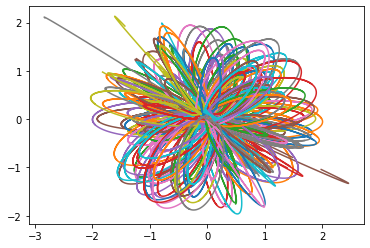

In [18]:
for i in range(200):
    plt.plot(data_list[i][:,0], data_list[i][:,1])
plt.show()

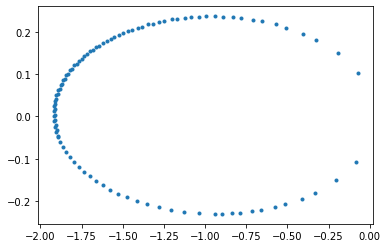

tensor([-1.8904, -0.0452, -0.1144,  0.1224])


In [19]:
plt.plot(data_list[25][:,0], data_list[25][:,1], '.')
plt.show()
print(data_list[25][0,:])

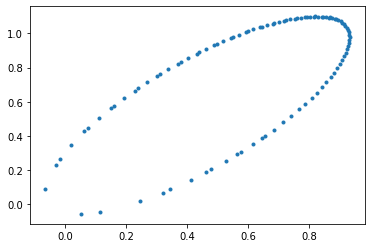

In [20]:
plt.plot(data_list[34][:,0], data_list[34][:,1], '.')
plt.show()

In [21]:
a = data_list[32][0]
a[0]/a[1] - a[2]/a[3]

tensor(1.8319)

In [22]:
idx = torch.randperm(len(data_list))[:10]
idx

tensor([54799, 47447,  7900, 21888, 52783, 39175, 42404, 47872,  1088, 31342])

In [23]:
data_t = torch.stack(data_list, dim=2).permute(2,0,1)
data_t.shape

torch.Size([58864, 101, 4])

In [24]:
data_t

tensor([[[-1.0680,  0.0861, -0.1433,  0.1187],
         [-1.0781,  0.0976, -0.0584,  0.1114],
         [-1.0797,  0.1083,  0.0262,  0.1033],
         ...,
         [-0.8593,  0.0111, -0.7327,  0.1426],
         [-0.9261,  0.0253, -0.6074,  0.1401],
         [-0.9813,  0.0391, -0.4978,  0.1364]],

        [[ 0.9176,  0.7027, -0.1820,  0.1905],
         [ 0.8965,  0.7196, -0.2403,  0.1448],
         [ 0.8696,  0.7316, -0.2994,  0.0963],
         ...,
         [ 0.4423,  0.6150, -0.8543, -0.5034],
         [ 0.3514,  0.5568, -0.9659, -0.6689],
         [ 0.2482,  0.4787, -1.1051, -0.9117]],

        [[-1.2310, -1.1597, -0.1413,  0.1436],
         [-1.2439, -1.1442, -0.1164,  0.1668],
         [-1.2542, -1.1264, -0.0904,  0.1904],
         ...,
         [-1.1275, -1.2029, -0.2704,  0.0136],
         [-1.1533, -1.2002, -0.2454,  0.0400],
         [-1.1765, -1.1949, -0.2204,  0.0657]],

        ...,

        [[ 0.6670,  1.2329, -0.1645,  0.1676],
         [ 0.6494,  1.2475, -0.1878,  0.1238]

## Implement Dataset

In [25]:
class Kepler2D(torch.utils.data.Dataset):
    def __init__(self, data_list, n):
        assert n < len(data_list)
        idx = torch.randperm(len(data_list))[:n]
        data_t = torch.stack(data_list, dim=2).permute(2, 0, 1)
        data_t = data_t[idx]
        row = data_t.shape[1]
        
        # Positive Pair
        pts = torch.vstack([torch.randperm(row)[:3] for i in range(n)]) # 각 궤도에서 랜덤으로 점 3개 선택
        X = torch.Tensor(n, 4)
        X_p = torch.Tensor(n, 4)
        X_n = torch.Tensor(n, 4)
        X_n[0,:] = data_t[n-1,pts[0,2],:]
        for i in range(n):
            X[i,:] = data_t[i,pts[i,0],:]
            X_p[i,:] = data_t[i,pts[i,1],:]
            if i > 0:
                X_n[i,:] = data_t[i-1,pts[i,2],:]  # Positive pair들의 다음 궤도 선택 (항상 다른 궤도 보장)
        
        # Mix Pairs with label
        self.X = torch.vstack([X, X])
        self.X_pair = torch.vstack([X_p, X_n])
        
        # Labelling
        y_p = torch.zeros((X_p.shape[0], 1))
        y_n = torch.ones((X_n.shape[0], 1))
        self.y = torch.vstack([y_p, y_n])
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = torch.Tensor(self.X[idx])
        x_pair = torch.Tensor(self.X_pair[idx])
        y = torch.Tensor(self.y[idx])
        return x, x_pair, y

In [26]:
# t_train = (0, 10, 100)
# t_valid = (0, 10, 100)

In [27]:
train_dataset = Kepler2D(data_list, 50000)
valid_dataset = Kepler2D(data_list, 5000)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=500)

dataloaders_dict = {
    "train": train_dataloader,
    "val": valid_dataloader
}

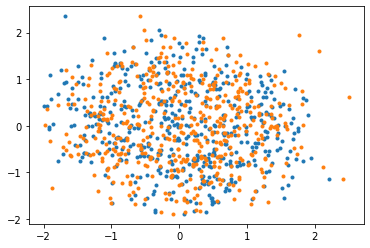

In [28]:
for _, samples in enumerate(train_dataloader):
    x, x_p, y = samples
    
    plt.plot(x[:,0], x[:,1], '.')
    plt.plot(x_p[:,0], x[:,1], '.')
    plt.show()
    break

## Implement Siamese Network

In [29]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(4,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.ReLU()
        )

    def forward(self, x1, x2):
        out1 = self.linear_relu(x1)
        out2 = self.linear_relu(x2)
        return out1, out2

In [30]:
net = SNN()
print(net)

SNN(
  (linear_relu): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): ReLU()
  )
)


## Implement Contrastive Loss (Hadsell)

In [31]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [32]:
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [33]:
def train(net, dataloaders_dict, criterion, optimizer, num_epochs, dist=1):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("----------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corr = 0
            
            data = dataloaders_dict[phase]
            for batch, samples in enumerate(tqdm(data)):
                X, X_p, y = samples
                X, X_p, y = X.to(device), X_p.to(device), y.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    out1, out2 = net(X, X_p)
                    loss = criterion(out1, out2, y)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() + X.shape[0]
                    epoch_corr += torch.count_nonzero((torch.abs(out1 - out2) <= dist) != y).item()
                    
            epoch_loss = epoch_loss / len(data.dataset)
            epoch_acc = epoch_corr / len(data.dataset)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
                lr = scheduler._last_lr[0]
                print(f" Validation Loss: {epoch_loss:>8f}")
                print(f" Validation Acc : {epoch_acc:>8f}")
                print(f" Learning Rate  : {lr:>8f}\n")
                if lr < 1e-6:
                    return train_loss, val_loss
            
    return train_loss, val_loss

In [34]:
train_loss, val_loss = train(net, dataloaders_dict, criterion, optimizer, 500, 0.6)

  8%|▊         | 16/200 [00:00<00:01, 155.03it/s]

Epoch 1/500
----------------------


  8%|▊         | 15/200 [00:00<00:01, 144.96it/s]

 Validation Loss: 1.001026
 Validation Acc : 0.849300
 Learning Rate  : 0.010000

Epoch 2/500
----------------------


  8%|▊         | 15/200 [00:00<00:01, 142.40it/s]

 Validation Loss: 1.000964
 Validation Acc : 0.849900
 Learning Rate  : 0.010000

Epoch 3/500
----------------------


  8%|▊         | 15/200 [00:00<00:01, 144.77it/s]

 Validation Loss: 1.000896
 Validation Acc : 0.876300
 Learning Rate  : 0.010000

Epoch 4/500
----------------------


  8%|▊         | 16/200 [00:00<00:01, 158.93it/s]

 Validation Loss: 1.000843
 Validation Acc : 0.879300
 Learning Rate  : 0.010000

Epoch 5/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 171.73it/s]

 Validation Loss: 1.000832
 Validation Acc : 0.884200
 Learning Rate  : 0.010000

Epoch 6/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 182.43it/s]

 Validation Loss: 1.000877
 Validation Acc : 0.872000
 Learning Rate  : 0.010000

Epoch 7/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 162.77it/s]

 Validation Loss: 1.000806
 Validation Acc : 0.890900
 Learning Rate  : 0.010000

Epoch 8/500
----------------------


  6%|▌         | 12/200 [00:00<00:01, 113.33it/s]

 Validation Loss: 1.000822
 Validation Acc : 0.890800
 Learning Rate  : 0.010000

Epoch 9/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 161.52it/s]

 Validation Loss: 1.000781
 Validation Acc : 0.891300
 Learning Rate  : 0.010000

Epoch 10/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 169.62it/s]

 Validation Loss: 1.000842
 Validation Acc : 0.881700
 Learning Rate  : 0.010000

Epoch 11/500
----------------------


  6%|▌         | 12/200 [00:00<00:01, 115.05it/s]

 Validation Loss: 1.000844
 Validation Acc : 0.880500
 Learning Rate  : 0.010000

Epoch 12/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 169.30it/s]

 Validation Loss: 1.000816
 Validation Acc : 0.885200
 Learning Rate  : 0.010000

Epoch 13/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 174.30it/s]

 Validation Loss: 1.000848
 Validation Acc : 0.863900
 Learning Rate  : 0.010000

Epoch 14/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 162.75it/s]

 Validation Loss: 1.000961
 Validation Acc : 0.890600
 Learning Rate  : 0.010000

Epoch 15/500
----------------------


  8%|▊         | 16/200 [00:00<00:01, 153.09it/s]

 Validation Loss: 1.000778
 Validation Acc : 0.892600
 Learning Rate  : 0.010000

Epoch 16/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 165.36it/s]

 Validation Loss: 1.000791
 Validation Acc : 0.887800
 Learning Rate  : 0.010000

Epoch 17/500
----------------------


  8%|▊         | 16/200 [00:00<00:01, 149.92it/s]

 Validation Loss: 1.000866
 Validation Acc : 0.872100
 Learning Rate  : 0.010000

Epoch 18/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 174.48it/s]

 Validation Loss: 1.000788
 Validation Acc : 0.887700
 Learning Rate  : 0.010000

Epoch 19/500
----------------------


  6%|▋         | 13/200 [00:00<00:01, 129.49it/s]

 Validation Loss: 1.000784
 Validation Acc : 0.887600
 Learning Rate  : 0.010000

Epoch 20/500
----------------------


  8%|▊         | 15/200 [00:00<00:01, 142.80it/s]

 Validation Loss: 1.000857
 Validation Acc : 0.870600
 Learning Rate  : 0.001000

Epoch 21/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 173.34it/s]

 Validation Loss: 1.000728
 Validation Acc : 0.904900
 Learning Rate  : 0.001000

Epoch 22/500
----------------------


  6%|▋         | 13/200 [00:00<00:01, 119.14it/s]

 Validation Loss: 1.000733
 Validation Acc : 0.905300
 Learning Rate  : 0.001000

Epoch 23/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 169.01it/s]

 Validation Loss: 1.000724
 Validation Acc : 0.905300
 Learning Rate  : 0.001000

Epoch 24/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 174.06it/s]

 Validation Loss: 1.000727
 Validation Acc : 0.903600
 Learning Rate  : 0.001000

Epoch 25/500
----------------------


  4%|▍         | 9/200 [00:00<00:02, 85.35it/s]

 Validation Loss: 1.000729
 Validation Acc : 0.904300
 Learning Rate  : 0.001000

Epoch 26/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 186.15it/s]

 Validation Loss: 1.000724
 Validation Acc : 0.905000
 Learning Rate  : 0.001000

Epoch 27/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 169.25it/s]

 Validation Loss: 1.000725
 Validation Acc : 0.906200
 Learning Rate  : 0.001000

Epoch 28/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 170.71it/s]

 Validation Loss: 1.000729
 Validation Acc : 0.904300
 Learning Rate  : 0.001000

Epoch 29/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 169.83it/s]

 Validation Loss: 1.000724
 Validation Acc : 0.906200
 Learning Rate  : 0.001000

Epoch 30/500
----------------------


  8%|▊         | 15/200 [00:00<00:01, 147.76it/s]

 Validation Loss: 1.000727
 Validation Acc : 0.904600
 Learning Rate  : 0.001000

Epoch 31/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 169.22it/s]

 Validation Loss: 1.000721
 Validation Acc : 0.904300
 Learning Rate  : 0.000100

Epoch 32/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 167.17it/s]

 Validation Loss: 1.000717
 Validation Acc : 0.907100
 Learning Rate  : 0.000100

Epoch 33/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 169.62it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.906800
 Learning Rate  : 0.000100

Epoch 34/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 170.91it/s]

 Validation Loss: 1.000717
 Validation Acc : 0.907500
 Learning Rate  : 0.000100

Epoch 35/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 172.44it/s]

 Validation Loss: 1.000717
 Validation Acc : 0.907000
 Learning Rate  : 0.000100

Epoch 36/500
----------------------


  6%|▌         | 11/200 [00:00<00:01, 108.18it/s]

 Validation Loss: 1.000718
 Validation Acc : 0.906800
 Learning Rate  : 0.000100

Epoch 37/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 171.59it/s]

 Validation Loss: 1.000718
 Validation Acc : 0.907500
 Learning Rate  : 0.000100

Epoch 38/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 179.20it/s]

 Validation Loss: 1.000717
 Validation Acc : 0.905900
 Learning Rate  : 0.000100

Epoch 39/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 182.99it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907100
 Learning Rate  : 0.000100

Epoch 40/500
----------------------


  8%|▊         | 16/200 [00:00<00:01, 158.45it/s]

 Validation Loss: 1.000717
 Validation Acc : 0.907000
 Learning Rate  : 0.000100

Epoch 41/500
----------------------


  7%|▋         | 14/200 [00:00<00:01, 139.41it/s]

 Validation Loss: 1.000717
 Validation Acc : 0.907500
 Learning Rate  : 0.000100

Epoch 42/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 164.20it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907500
 Learning Rate  : 0.000010

Epoch 43/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 182.67it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907300
 Learning Rate  : 0.000010

Epoch 44/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 167.46it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907200
 Learning Rate  : 0.000010

Epoch 45/500
----------------------


  8%|▊         | 16/200 [00:00<00:01, 157.09it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907500
 Learning Rate  : 0.000010

Epoch 46/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 161.22it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907600
 Learning Rate  : 0.000010

Epoch 47/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 168.58it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907300
 Learning Rate  : 0.000010

Epoch 48/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 169.80it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907200
 Learning Rate  : 0.000010

Epoch 49/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 167.25it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907400
 Learning Rate  : 0.000010

Epoch 50/500
----------------------


  4%|▍         | 9/200 [00:00<00:02, 78.17it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907300
 Learning Rate  : 0.000010

Epoch 51/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 166.72it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907200
 Learning Rate  : 0.000010

Epoch 52/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 169.78it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907600
 Learning Rate  : 0.000010

Epoch 53/500
----------------------


  7%|▋         | 14/200 [00:00<00:01, 134.26it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907400
 Learning Rate  : 0.000001

Epoch 54/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 171.70it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907300
 Learning Rate  : 0.000001

Epoch 55/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 173.60it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907300
 Learning Rate  : 0.000001

Epoch 56/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 173.89it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907300
 Learning Rate  : 0.000001

Epoch 57/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 178.35it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907300
 Learning Rate  : 0.000001

Epoch 58/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 171.84it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907400
 Learning Rate  : 0.000001

Epoch 59/500
----------------------


 10%|█         | 20/200 [00:00<00:00, 192.73it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907400
 Learning Rate  : 0.000001

Epoch 60/500
----------------------


 10%|█         | 20/200 [00:00<00:00, 196.16it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907400
 Learning Rate  : 0.000001

Epoch 61/500
----------------------


 10%|▉         | 19/200 [00:00<00:01, 145.22it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907300
 Learning Rate  : 0.000001

Epoch 62/500
----------------------


 10%|█         | 20/200 [00:00<00:00, 195.07it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907300
 Learning Rate  : 0.000001

Epoch 63/500
----------------------


 10%|█         | 20/200 [00:00<00:00, 195.25it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907300
 Learning Rate  : 0.000001

Epoch 64/500
----------------------


100%|██████████| 20/20 [00:00<00:00, 201.20it/s]

 Validation Loss: 1.000716
 Validation Acc : 0.907400
 Learning Rate  : 0.000000



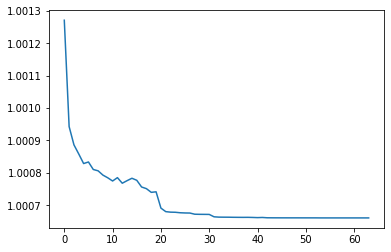

In [35]:
plt.plot(train_loss)
plt.show()

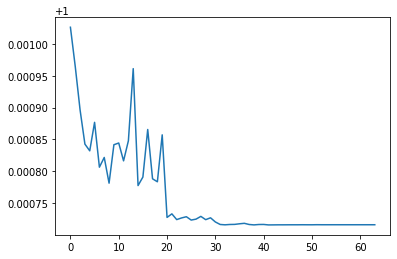

In [36]:
plt.plot(val_loss)
plt.show()

In [37]:
anc1, pos, ans1 = train_dataset[0:10]
anc2, neg, ans2 = train_dataset[-10:]

In [38]:
with torch.no_grad():
    a, b = net(anc1, pos)
    res1 = torch.column_stack([a, b])
    print(res1)

tensor([[3.6600e-01, 1.0620e+00],
        [2.3157e+00, 2.1570e+00],
        [7.2797e+00, 7.2253e+00],
        [7.7720e+00, 7.8382e+00],
        [9.6652e+00, 9.0786e+00],
        [7.4387e+00, 7.4344e+00],
        [4.5146e+00, 4.5591e+00],
        [4.0218e-01, 4.6739e-01],
        [1.0422e+01, 1.0527e+01],
        [9.7103e-03, 1.3084e-01]])


In [39]:
with torch.no_grad():
    c, d = net(anc2, neg)
    res2 = torch.column_stack([c, d])
    print(res2)

tensor([[8.2742, 9.6348],
        [0.1119, 8.4107],
        [8.5573, 0.0880],
        [0.3617, 8.7241],
        [8.1564, 0.4860],
        [0.9811, 8.2582],
        [7.5717, 0.9528],
        [2.2440, 7.5146],
        [7.6559, 2.1892],
        [0.6039, 7.6116]])


In [40]:
torch.save(net, "model/snn_kepl2d_01.pt")